In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from torch.utils.data import TensorDataset
from pathlib import Path
import random
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from two_spirals_utils import spiral_dataset, SpiralClassifier
from utils.utils import get_grid_predictions, create_contour_plot, resnet_CIFAR10
from utils.attacks import fgsm, pgd

import tarfile
import os

import datetime
import math


In [2]:
# Assuming the checkpoint is stored at './resnet_checkpoint.pth'
checkpoint_path = '../models/resnet/resnet50_cifar10.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create an instance of the model
classifier = resnet_CIFAR10(resnet_checkpoint=checkpoint_path, device=device)

# CIFAR10 class labels for reference
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# Load the CIFAR10 dataset
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

tensor = transforms.ToTensor()

class UnNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be unnormalized.
        Returns:
            Tensor: Unnormalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)  # Multiply by std dev and add mean
        return tensor

# Define the mean and std dev as per your normalization
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Create an instance of the UnNormalize class
unnormalize = UnNormalize(mean, std)


In [4]:
idx = np.random.randint(1, 1000)
eps = 0.055



In [5]:
from manifold_flow.flows import ManifoldFlow
from manifold_flow import transforms
from manifold_flow.architectures.vector_transforms import create_vector_transform
from manifold_flow.architectures.image_transforms import create_image_transform


latentdim = 500
outerlayers = 20
innerlayers = 6
levels = 4
splinebins = 11
splinerange = 10.0
dropout = 0.0
actnorm = True
batchnorm = False
contextfeatures = None
linlayers = 2
linchannelfactor = 1
lineartransform = "lu"

steps_per_level = outerlayers // levels

mflow = ManifoldFlow(
        data_dim=(3, 32, 32),
        latent_dim=latentdim,
        inner_transform = create_vector_transform(
            dim = latentdim,
            flow_steps = 16 , # previously 6
            linear_transform_type = "permutation",
            base_transform_type = "rq-coupling",
            hidden_features = 100,
            num_transform_blocks = 6, #previously 2
            dropout_probability=0.0,
            use_batch_norm=False,
            num_bins=8,
            tail_bound=3,
            apply_unconditional_transform=False,
            context_features=None,
        ),
        outer_transform=create_image_transform(
            3,
            32,
            32,
            levels=4,
            hidden_channels=100,
            steps_per_level=steps_per_level,
            num_res_blocks=2,
            alpha=0.05,
            num_bits=8,
            preprocessing="glow",
            dropout_prob=dropout,
            multi_scale=True,
            num_bins=splinebins,
            tail_bound=splinerange,
            postprocessing="partial_nsf",
            postprocessing_layers=linlayers,
            postprocessing_channel_factor=linchannelfactor,
            use_actnorm=actnorm,
            use_batchnorm=batchnorm,
        )
    )

# Load model state dict on CPU
mflow.load_state_dict(torch.load("../models/cifar10_mflow/mflow_cifar10_nsamples50000_normalized_dim500_run0.pt", map_location=torch.device(device)))

<All keys matched successfully>

In [6]:
def safe_extract(member):
    print(f"Extracting: {member.name}")
    return member

file_path = f"../data/cifar10_attacked/cifar10_pgd_eps_{eps:.3f}.tar.gz"
extraction_path = "../data/cifar10_attacked/"

with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall(path = extraction_path, members=(safe_extract(m) for m in tar.getmembers()))


data_adv = torch.load(file_path.replace("tar.gz", "pt"), map_location=device)
data_orig = datasets.CIFAR10(root='./data', train=False, download=True, transform=tensor)

original_image = data_orig[idx][0]
adversarial_image = data_adv[idx][0]



x_latent = mflow.encode(normalize(adversarial_image).unsqueeze(0))

# Project adversarial attack sample onto manifold
x_proj   = mflow.decode(x_latent).detach()

projected_image = unnormalize(x_proj)

with torch.no_grad():
    pred_def = classifier(x_proj)
    pred_def = pred_def.argmax(axis=1)

    pred_orig = classifier(normalize(original_image).unsqueeze(0))
    pred_orig = pred_orig.argmax(axis=1)

    pred_adv = classifier(normalize(adversarial_image).unsqueeze(0))
    pred_adv = pred_adv.argmax(axis=1)

       

/var/folders/dr/07tl1lzs7_g29ddcffd8hmr00000gn/T/ipykernel_8617/3200007574.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path = extraction_path, members=(safe_extract(m) for m in tar.getmembers()))


Extracting: cifar10_pgd_eps_0.055.pt
Files already downloaded and verified


In [7]:
idx

784

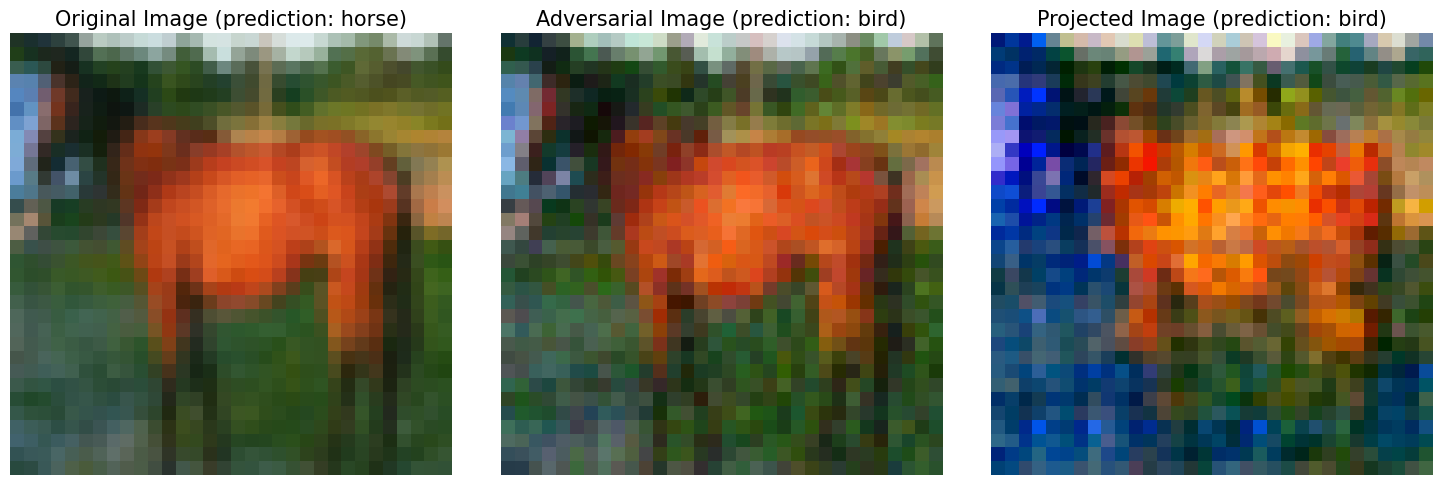

In [8]:
img1 = original_image.permute(1, 2, 0)
img2 = adversarial_image.permute(1, 2, 0)
img3 = projected_image.squeeze().permute(1, 2, 0)


if eps == 0.000:
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Plot each image on its respective axis
    axs[0].imshow(img1)
    axs[0].set_title(f"Original Image (prediction: {classes[pred_orig]})", fontsize = 15)
    axs[0].axis('off')  # Turn off axis

    axs[1].imshow(img3)
    axs[1].set_title(f"Projected Image (prediction: {classes[pred_def]})", fontsize = 15)
    axs[1].axis('off')  # Turn off axis

    # Display the plot
    plt.tight_layout(pad=2.0)  # Adjust layout to not overlap
    # plt.savefig(f"../figures/report/attack_eps_{eps:.3f}_image_sample_{idx}.pdf")
    plt.show()

else:
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Plot each image on its respective axis
    axs[0].imshow(img1)
    axs[0].set_title(f"Original Image (prediction: {classes[pred_orig]})", fontsize = 15)
    axs[0].axis('off')  # Turn off axis

    axs[1].imshow(img2)
    axs[1].set_title(f"Adversarial Image (prediction: {classes[pred_adv]})", fontsize = 15)
    axs[1].axis('off')  # Turn off axis

    axs[2].imshow(img3)
    axs[2].set_title(f"Projected Image (prediction: {classes[pred_def]})", fontsize = 15)
    axs[2].axis('off')  # Turn off axis

    # Display the plot

    plt.tight_layout(pad=2.0)  # Adjust layout to not overlap
    # plt.savefig(f"../figures/report/attack_eps_{eps:.3f}_image_sample_{idx}.pdf")
    plt.show()